In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from dataloader import TRAILDataset


In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Functions

In [38]:
def create_sequences(data, input_length=14, output_length=4):
    X, y = [], []
    for i in tqdm(range(len(data) - input_length - output_length + 1), desc="Generating sequences"):
        X.append(data[i:i+input_length])
        y.append(data[i+input_length:i+input_length+output_length])
    return np.array(X), np.array(y)


In [39]:
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

def nmse(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2) / torch.mean(y_true ** 2)

def mape(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

In [40]:
def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc='Validation'):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [41]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc='Training'):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss = validate_model(model, criterion, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [42]:
def test_model(model, test_loader, predict_scaler):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            # apply reverse scaling
            y_batch_ = predict_scaler.inverse_transform(y_batch.cpu().numpy())
            outputs_ = predict_scaler.inverse_transform(outputs.cpu().numpy())
        
            y_true.append(y_batch_)
            y_pred.append(outputs_)
    
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
            
    
    
    mse_per_output = []
    rmse_per_output = []
    nmse_per_output = []
    mape_per_output = []
    
    for i in range(y_true.shape[1]):
        mse_value = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse_value = np.sqrt(mse_value)
        nmse_value = np.mean((y_true[:, i] - y_pred[:, i]) ** 2) / np.mean(y_true[:, i] ** 2)
        mape_value = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i])

        mse_per_output.append(mse_value)
        rmse_per_output.append(rmse_value)
        nmse_per_output.append(nmse_value)
        mape_per_output.append(mape_value)

        #print(f"Output {i+1}: MSE: {mse_value:.4f}, RMSE: {rmse_value:.4f}, NMSE: {nmse_value:.4f}, MAPE: {mape_value:.4f}%")
        print(f"Output {i+1}: MSE: {mse_value:.4f}, RMSE: {rmse_value:.4f}")
    
    return mse_per_output, rmse_per_output, nmse_per_output, mape_per_output

In [43]:
def get_predictions(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            
            y_true.append(y_batch.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    
    return y_true, y_pred

In [44]:
def plot_true_vs_predicted(y_true, y_pred, time=None):
    if time is None:
        time = np.arange(len(y_true))
    
    plt.figure(figsize=(12, 6))
    plt.plot(time, y_true, color='blue', label='True Values', linestyle='-', marker='o')
    plt.plot(time, y_pred, color='red', label='Predicted Values', linestyle='--', marker='x')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('True Values vs Predicted Values')
    plt.legend()
    plt.show()


In [45]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


MLP

In [46]:
class MLPRegressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [47]:
LAG = 14
HORIZON = 4
LEARNING_RATE = 0.003
EPOCHS = 50
BATCH_SIZE = 128

Loading the data and splitting it into training, validation, and test sets

In [48]:
csv_file = "Processed_data.csv"
df = pd.read_csv(csv_file, sep=",") 
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

In [49]:
df_train = df[df["Year"] < 2023]
df_val = df[df["Year"] == 2023]
df_test = df[df["Year"] == 2024]

In [50]:
columns_input = ["Total Load"]  
column_to_predict = "Total Load"
column_to_normalize = ["Total Load"]

In [51]:
#train_datasetset = TRAILDataset(df_train, len(df_train), columns_input, column_to_predict, column_to_normalize, scaler=StandardScaler(), predict_scaler=StandardScaler())
train_dataset = TRAILDataset(df_train, len(df_train), columns_input, column_to_predict, column_to_normalize)

scaler = train_dataset.get_scaler()
predict_scaler = train_dataset.get_predict_scaler()

train_dataset.save_scaler()

predict_scaler = train_dataset.get_predict_scaler()
print("train dataset loaded")
print(column_to_normalize)

val_dataset = TRAILDataset(df_val, len(df_val), columns_input, column_to_predict, column_to_normalize, scaler=scaler, predict_scaler=predict_scaler)
print("validation dataset loaded")

test_dataset = TRAILDataset(df_test, len(df_test), columns_input, column_to_predict, column_to_normalize, scaler=scaler, predict_scaler=predict_scaler)
print("test dataset loaded")


train dataset loaded
['Total Load']
validation dataset loaded
test dataset loaded


c:\Users\tojov\Desktop\Workshop_2024\project9\dataloader.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.column_to_predict] = scaled_row
c:\Users\tojov\Desktop\Workshop_2024\project9\dataloader.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.column_to_predict] = scaled_row
c:\Users\tojov\Desktop\Workshop_2024\project9\dataloader.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sequence generation

In [52]:
X_train, y_train = create_sequences(train_dataset.data['Total Load'], input_length=LAG, output_length=HORIZON)
X_val, y_val = create_sequences(val_dataset.data['Total Load'], input_length=LAG, output_length=HORIZON)
X_test, y_test = create_sequences(test_dataset.data['Total Load'], input_length=LAG, output_length=HORIZON)

Generating sequences: 100%|██████████| 22554/22554 [00:02<00:00, 10688.21it/s]


In [53]:
train_dataset = data.TensorDataset(torch.tensor(X_train, dtype=torch.float32).view(-1, 14), 
                                   torch.tensor(y_train, dtype=torch.float32).view(-1, 4))

val_dataset = data.TensorDataset(torch.tensor(X_val, dtype=torch.float32).view(-1, 14), 
                                 torch.tensor(y_val, dtype=torch.float32).view(-1, 4))

test_dataset = data.TensorDataset(torch.tensor(X_test, dtype=torch.float32).view(-1, 14), 
                                  torch.tensor(y_test, dtype=torch.float32).view(-1, 4))

In [54]:
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Model creation and training

In [55]:
# MLP
model =  MLPRegressor(input_size=LAG, output_size=HORIZON)

In [56]:
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [57]:
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS)  

Validation: 100%|██████████| 274/274 [00:00<00:00, 883.68it/s]


Epoch 1/50, Training Loss: 0.0024, Validation Loss: 0.0012


Validation: 100%|██████████| 274/274 [00:00<00:00, 884.99it/s]


Epoch 2/50, Training Loss: 0.0010, Validation Loss: 0.0015


Validation: 100%|██████████| 274/274 [00:00<00:00, 729.69it/s]


Epoch 3/50, Training Loss: 0.0009, Validation Loss: 0.0014


Validation: 100%|██████████| 274/274 [00:00<00:00, 685.70it/s]


Epoch 4/50, Training Loss: 0.0008, Validation Loss: 0.0017


Validation: 100%|██████████| 274/274 [00:00<00:00, 737.05it/s]


Epoch 5/50, Training Loss: 0.0008, Validation Loss: 0.0014


Validation: 100%|██████████| 274/274 [00:00<00:00, 642.52it/s]


Epoch 6/50, Training Loss: 0.0008, Validation Loss: 0.0016


Validation: 100%|██████████| 274/274 [00:00<00:00, 769.15it/s]


Epoch 7/50, Training Loss: 0.0007, Validation Loss: 0.0018


Validation: 100%|██████████| 274/274 [00:00<00:00, 578.91it/s]


Epoch 8/50, Training Loss: 0.0007, Validation Loss: 0.0012


Validation: 100%|██████████| 274/274 [00:00<00:00, 761.45it/s]


Epoch 9/50, Training Loss: 0.0007, Validation Loss: 0.0012


Validation: 100%|██████████| 274/274 [00:00<00:00, 687.51it/s]


Epoch 10/50, Training Loss: 0.0007, Validation Loss: 0.0012


Validation: 100%|██████████| 274/274 [00:00<00:00, 913.38it/s]


Epoch 11/50, Training Loss: 0.0007, Validation Loss: 0.0013


Validation: 100%|██████████| 274/274 [00:00<00:00, 839.06it/s]


Epoch 12/50, Training Loss: 0.0007, Validation Loss: 0.0011


Validation: 100%|██████████| 274/274 [00:00<00:00, 884.16it/s]


Epoch 13/50, Training Loss: 0.0007, Validation Loss: 0.0012


Validation: 100%|██████████| 274/274 [00:00<00:00, 862.33it/s]


Epoch 14/50, Training Loss: 0.0007, Validation Loss: 0.0011


Validation: 100%|██████████| 274/274 [00:00<00:00, 913.89it/s]


Epoch 15/50, Training Loss: 0.0007, Validation Loss: 0.0013


Validation: 100%|██████████| 274/274 [00:00<00:00, 922.33it/s]


Epoch 16/50, Training Loss: 0.0007, Validation Loss: 0.0011


Validation: 100%|██████████| 274/274 [00:00<00:00, 906.74it/s]


Epoch 17/50, Training Loss: 0.0007, Validation Loss: 0.0010


Validation: 100%|██████████| 274/274 [00:00<00:00, 913.92it/s]


Epoch 18/50, Training Loss: 0.0006, Validation Loss: 0.0011


Validation: 100%|██████████| 274/274 [00:00<00:00, 886.31it/s]


Epoch 19/50, Training Loss: 0.0006, Validation Loss: 0.0010


Validation: 100%|██████████| 274/274 [00:00<00:00, 889.36it/s]


Epoch 20/50, Training Loss: 0.0006, Validation Loss: 0.0010


Validation: 100%|██████████| 274/274 [00:00<00:00, 902.92it/s]


Epoch 21/50, Training Loss: 0.0006, Validation Loss: 0.0009


Validation: 100%|██████████| 274/274 [00:00<00:00, 896.09it/s]


Epoch 22/50, Training Loss: 0.0006, Validation Loss: 0.0009


Validation: 100%|██████████| 274/274 [00:00<00:00, 898.90it/s]


Epoch 23/50, Training Loss: 0.0006, Validation Loss: 0.0010


Validation: 100%|██████████| 274/274 [00:00<00:00, 900.76it/s]


Epoch 24/50, Training Loss: 0.0006, Validation Loss: 0.0010


Validation: 100%|██████████| 274/274 [00:00<00:00, 870.37it/s]


Epoch 25/50, Training Loss: 0.0006, Validation Loss: 0.0010


Validation: 100%|██████████| 274/274 [00:00<00:00, 895.26it/s]


Epoch 26/50, Training Loss: 0.0006, Validation Loss: 0.0009


Validation: 100%|██████████| 274/274 [00:00<00:00, 878.07it/s]


Epoch 27/50, Training Loss: 0.0006, Validation Loss: 0.0010


Validation: 100%|██████████| 274/274 [00:00<00:00, 905.20it/s]


Epoch 28/50, Training Loss: 0.0006, Validation Loss: 0.0009


Validation: 100%|██████████| 274/274 [00:00<00:00, 913.87it/s]


Epoch 29/50, Training Loss: 0.0006, Validation Loss: 0.0009


Validation: 100%|██████████| 274/274 [00:00<00:00, 906.09it/s]


Epoch 30/50, Training Loss: 0.0006, Validation Loss: 0.0008


Validation: 100%|██████████| 274/274 [00:00<00:00, 913.00it/s]


Epoch 31/50, Training Loss: 0.0006, Validation Loss: 0.0008


Validation: 100%|██████████| 274/274 [00:00<00:00, 912.87it/s]


Epoch 32/50, Training Loss: 0.0006, Validation Loss: 0.0008


Validation: 100%|██████████| 274/274 [00:00<00:00, 856.47it/s]


Epoch 33/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 882.09it/s]


Epoch 34/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 906.12it/s]


Epoch 35/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 854.24it/s]


Epoch 36/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 831.88it/s]


Epoch 37/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 897.49it/s]


Epoch 38/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 792.53it/s]


Epoch 39/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 868.90it/s]


Epoch 40/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 881.93it/s]


Epoch 41/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 881.17it/s]


Epoch 42/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 887.52it/s]


Epoch 43/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 729.32it/s]


Epoch 44/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 685.21it/s]


Epoch 45/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 698.86it/s]


Epoch 46/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 759.15it/s]


Epoch 47/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 727.50it/s]


Epoch 48/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 748.22it/s]


Epoch 49/50, Training Loss: 0.0006, Validation Loss: 0.0007


Validation: 100%|██████████| 274/274 [00:00<00:00, 728.13it/s]

Epoch 50/50, Training Loss: 0.0006, Validation Loss: 0.0007


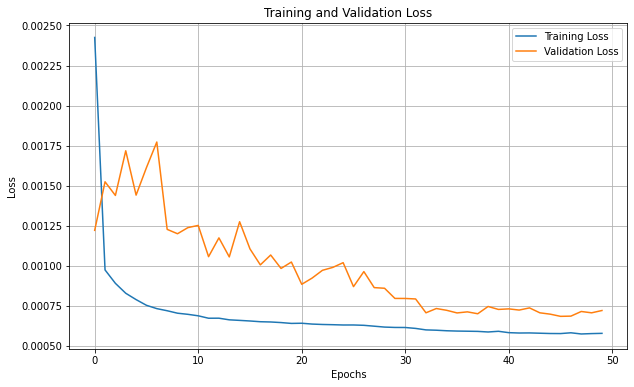

In [58]:
plot_losses(train_losses, val_losses)

In [59]:
mse_values, rmse_values, nmse_values, mape_values = test_model(model, test_loader, predict_scaler)

Output 1: MSE: 12349.2871, RMSE: 111.1273
Output 2: MSE: 25231.8594, RMSE: 158.8454
Output 3: MSE: 45837.8359, RMSE: 214.0977
Output 4: MSE: 76476.3828, RMSE: 276.5436


In [60]:
y_true, y_pred = get_predictions(model, test_loader)
y_true, y_pred = y_true.reshape(-1) , y_pred.reshape(-1)

# apply reverse scaling
y_true = predict_scaler.inverse_transform(y_true.reshape(-1,1))
y_pred = predict_scaler.inverse_transform(y_pred.reshape(-1,1))


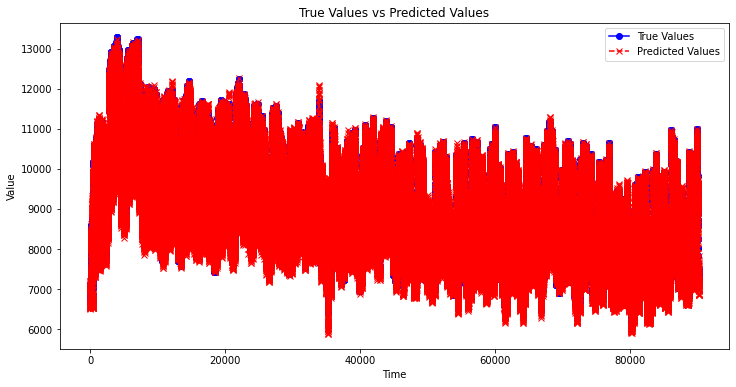

In [61]:
plot_true_vs_predicted(y_true, y_pred)